### 1. Modeling and System Identification

#### 1.1. Basic Knowledge

Nominal Transfer Functions

$G_{\theta , 0} = \dfrac{1547.4}{(s^2 + 10.12s + 390.4)(s + 5.373)}$

$G_{\phi , 0} = \dfrac{2049.5}{(s^2 + 19.03s + 426.2)(s + 6.764)}$

<br>

Unstructured Uncertainty -> Multiplicative Perturbation

$W_{\theta}(s) = \dfrac{1659.6(s^2 + 2.868s + 60.44)}{(s + 9.678)(s + 24770)}$

$W_{\phi}(s) = \dfrac{1.9017(s^2 + 3.813s + 91.61)}{(s^2 + 43.53s + 545.3)}$

#### Why Not MIMO?

Practical Constraints:
Open-loop instability made MIMO identification challenging.

Pilot difficulty during experiments (Section 2.1: "experimental data is better obtained for each channel separately").

Simplification:
The authors prioritized feasibility over theoretical MIMO rigor, noting that coupling effects were small near hover conditions.

####  Two-Stage Control Design (Casscade Architecture) -> Used for MIMO Systems, Uncertainty Reduction and Design Improvements

1. Inner Loop (Stabilization):

    A basic PID is used during system identification to stabilize the quadrotor and collect experimental data. This PID is crude but sufficient for safe hovering during data collection.
<br>

2. Outer Loop (Performance/Robustness):

    The $H_\infty$ controller is designed based on the identified closed-loop model (which includes the PID’s effects) and it augments it in a cascade architecture.
    
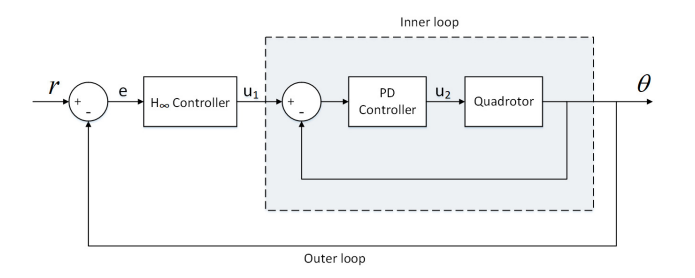

In [104]:
s = tf('s');

% Nominal Transfer functions
G_theta = 1547.4 / ((s^2 + 10.12*s + 390.4)*(s + 5.373))
G_phi = 2049.5 / ((s^2 + 19.03*s + 426.2)*(s + 6.764))

% Weighting Functions
W_theta = 1659.6*(s^2 + 2.868*s + 60.44) / ((s + 9.678)*(s + 24770))
W_phi = 1.9017*(s^2 + 3.813*s + 91.61) / (s^2 + 43.53*s + 545.3)


G_theta =
 
                1547
  --------------------------------
  s^3 + 15.49 s^2 + 444.8 s + 2098
 
Continuous-time transfer function.


G_phi =
 
                2050
  --------------------------------
  s^3 + 25.79 s^2 + 554.9 s + 2883
 
Continuous-time transfer function.


W_theta =
 
  1660 s^2 + 4760 s + 1.003e05
  ----------------------------
  s^2 + 2.478e04 s + 2.397e05
 
Continuous-time transfer function.


W_phi =
 
  1.902 s^2 + 7.251 s + 174.2
  ---------------------------
     s^2 + 43.53 s + 545.3
 
Continuous-time transfer function.



#### 1.2. Modeling Uncertain SISO Systems in Matlab

In [105]:
% Create uncertain systems
delta_theta = ultidyn('delta_theta', [1 1]); % [1 1] -> SISO Approach
delta_phi = ultidyn('delta_phi', [1 1]);

% Pertured Transfer Functions
G_theta_unc = G_theta * (1 + W_theta * delta_theta)
G_phi_unc = G_phi * (1 + W_phi * delta_phi)


G_theta_unc =

  Uncertain continuous-time state-space model with 1 outputs, 1 inputs, 5 states.
  The model uncertainty consists of the following blocks:
    delta_theta: Uncertain 1x1 LTI, peak gain = 1, 1 occurrences

Type "G_theta_unc.NominalValue" to see the nominal value, "get(G_theta_unc)" to see all properties, and "G_theta_unc.Uncertainty" to interact with the uncertain elements.


G_phi_unc =

  Uncertain continuous-time state-space model with 1 outputs, 1 inputs, 5 states.
  The model uncertainty consists of the following blocks:
    delta_phi: Uncertain 1x1 LTI, peak gain = 1, 1 occurrences

Type "G_phi_unc.NominalValue" to see the nominal value, "get(G_phi_unc)" to see all properties, and "G_phi_unc.Uncertainty" to interact with the uncertain elements.



#### 1.3. Uncertainty Visualization

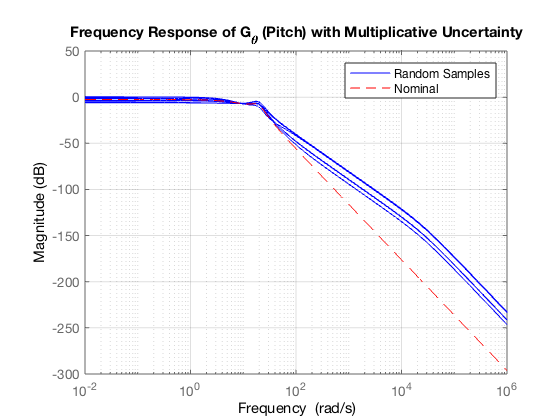

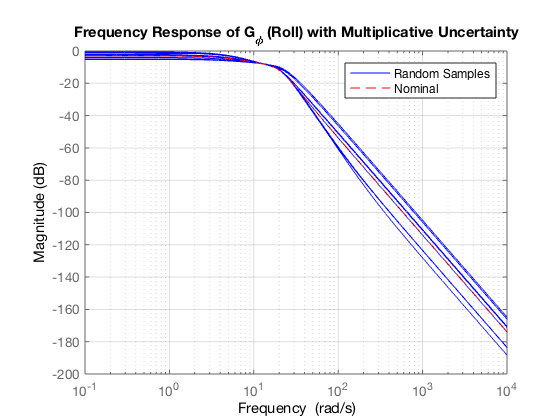

In [106]:
% Generate custom number of samples (The default number is 20)
num_samples = 10;
G_theta_samples = usample(G_theta_unc, num_samples);
G_phi_samples = usample(G_phi_unc, num_samples);

% Bode Plots of both Nominal and Uncertain Systems
figure;
bodemag(G_theta_samples, 'b', G_theta, 'r--');
title('Frequency Response of G_{\theta} (Pitch) with Multiplicative Uncertainty');
legend('Random Samples', 'Nominal');
grid on;

figure;
bodemag(G_phi_samples, 'b', G_phi, 'r--');
title('Frequency Response of G_{\phi} (Roll) with Multiplicative Uncertainty');
legend('Random Samples', 'Nominal');
grid on;

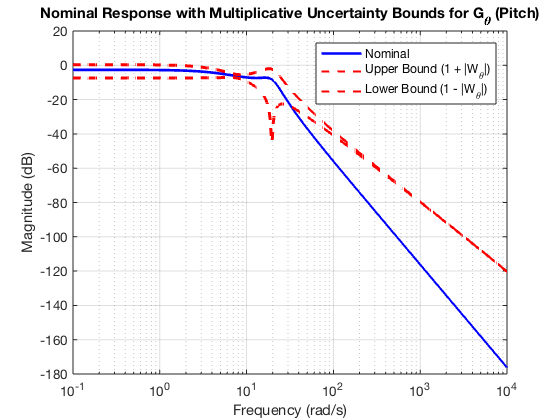

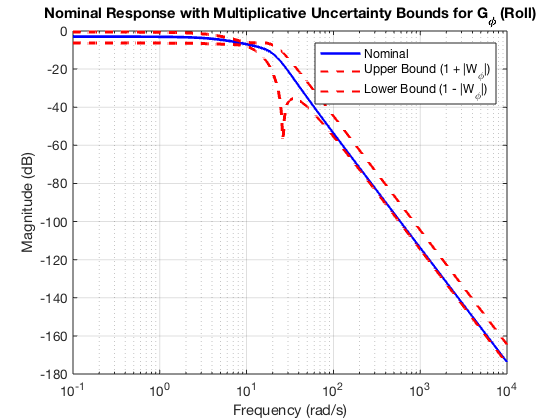

In [107]:
omega = logspace(-1, 4, 500);

% Frequency Responses
[mag_theta, phase_theta] = bode(G_theta, omega);
mag_theta = squeeze(mag_theta); % Remove singleton dimensions

[mag_W_theta, ~] = bode(W_theta, omega);
mag_W_theta = squeeze(mag_W_theta);

[mag_phi, phase_phi] = bode(G_phi, omega);
mag_phi = squeeze(mag_phi);

[mag_W_phi, ~] = bode(W_phi, omega);
mag_W_phi = squeeze(mag_W_phi);

% Uncertainty Bounds
upper_theta = mag_theta .* (1 + mag_W_theta);
lower_theta = mag_theta .* (1 - mag_W_theta);

upper_phi = mag_phi .* (1 + mag_W_phi);
lower_phi = mag_phi .* (1 - mag_W_phi);

% Plotting
figure;

% --- Pitch (G_theta) ---
semilogx(omega, 20*log10(mag_theta), 'b', 'LineWidth', 2); hold on;
semilogx(omega, 20*log10(upper_theta), 'r--', 'LineWidth', 1.5);
semilogx(omega, 20*log10(lower_theta), 'r--', 'LineWidth', 1.5);
title('Nominal Response with Multiplicative Uncertainty Bounds for G_\theta (Pitch)');
xlabel('Frequency (rad/s)');
ylabel('Magnitude (dB)');
legend('Nominal', 'Upper Bound (1 + |W_\theta|)', 'Lower Bound (1 - |W_\theta|)');
grid on;

% --- Roll (G_phi) ---
figure;
semilogx(omega, 20*log10(mag_phi), 'b', 'LineWidth', 2); hold on;
semilogx(omega, 20*log10(upper_phi), 'r--', 'LineWidth', 1.5);
semilogx(omega, 20*log10(lower_phi), 'r--', 'LineWidth', 1.5);
title('Nominal Response with Multiplicative Uncertainty Bounds for G_\phi (Roll)');
xlabel('Frequency (rad/s)');
ylabel('Magnitude (dB)');
legend('Nominal', 'Upper Bound (1 + |W_\phi|)', 'Lower Bound (1 - |W_\phi|)');
grid on;

#### 1.4. Objectives and Pre-requirements

Settling Time $\approx 0.3 s$

Overshoot $\approx 0$

Steady State Error $\approx 0$

Control Effort Limitations

### 2. Robust H∞ Control Synthesis

#### 2.1. Claculations of Weighting Functions

#### A) Sensivity Weighting Function</b>

Assumption: Second Order Closed-Loop System

Closed-Loop Transfer Function (Ideal Function):

$T_{cl}(s) = \dfrac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2}$

Peak Overshoot: (Step Input)

$M_p = exp(-\dfrac{\pi\zeta}{\sqrt{1 - \zeta^2}}) \approx 10^{-6}$

$\zeta = \dfrac{-ln(M_p)}{\sqrt{\pi^2 + (ln(M_p))^2}}$

Settling Time:

$t_s \approx \dfrac{4}{\zeta\omega_n} \approx 0.3s$

Solving peak overshoot criterion leads to:

In [108]:
Mp_desired = 1e-6; % Desired overshoot (e.g., 0.0001%)
zeta_solved = (-log(Mp_desired)) / sqrt(pi^2 + (log(Mp_desired))^2);
disp(['Required Damping Ratio: ', num2str(zeta_solved)]);

Required Damping Ratio: 0.97511


Also the natural frequency is obtained from settling time formula:

$t_s \approx \dfrac{4}{\zeta\omega_n} \approx 0.3s \Rightarrow \omega_n = \dfrac{4}{0.3\zeta} = 13.61 rad.s^{-1}$

In the next step, the ideal closed-loop transfer function is calculated:

$T_{id}(s) = \dfrac{\omega_n^2}{s^2 + 2\zeta\omega_ns + \omega_n^2} = \dfrac{185.23}{s^2 + 26.68s + 185.23}$

Finally the sensivity weighting function is as follows:

$W_s = a\dfrac{1}{S_{id}(s)} = a\dfrac{1}{1 - T_{id}(s)} = a\dfrac{s^2 + 26.68s + 185.23}{s(s + 26.68)}$

In order to be strictly proper and stable:

$W_s = a\dfrac{s^2 + 26.68s + 185.23}{(s + 0.001)(s + 26.68)(s + 1000)}$

#### B) Control Effort Weighting Function

$\lVert W_uU \lVert_\infty \leq 1; \lVert U \lVert_\infty \leq 20$

$\Rightarrow W_u = 0.05$

First Trial $\Rightarrow W_u = 1$

In [109]:
% Initial Weights
W_u = 1;
a = 1;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

% Build Generalized Plants
G_theta_p = augw(G_theta , W_s , W_u , W_theta);
G_phi_p = augw(G_phi , W_s , W_u , W_phi);

#### 2.2. H∞ Control Synthesis (Riccati Method)

In [110]:
% Synthesize H∞ Controller
[C_theta , CL1 , gamma1 , info1] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');
[C_phi , CL2 , gamma2 , info2] = hinfsyn(G_phi_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');


  Test bounds:  1.39 <=  gamma  <=  1.79

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  1.58e+00     1.3e-05     0.0e+00     1.208e-18     p
  1.48e+00     1.3e-05     0.0e+00     7.284e-17     p
  1.44e+00     1.3e-05     0.0e+00     1.020e-16     p
  1.41e+00     1.3e-05     0.0e+00     4.871e-17     p
  1.40e+00     1.3e-05     0.0e+00     9.412e-17     p

  Best performance (actual): 1.4

  Test bounds:  1.41 <=  gamma  <=  1.82

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  1.60e+00     1.3e-05     0.0e+00     2.054e-16     p
  1.50e+00     1.3e-05     0.0e+00     3.962e-19     p
  1.46e+00     1.3e-05     0.0e+00     1.922e-14     p
  1.43e+00     1.3e-05     0.0e+00     6.784e-16     p
  1.42e+00     1.3e-05     0.0e+00     6.733e-18     p

  Best performance (actual): 1.42


#### 2.3. Nominal Performance Analysis

#### A) Closed-Loop Response to Step Input

The figures show that the nominal system doesn't reach the final value of the unit step input. It can also be seen that the system response is too slow and the actuator saturation occurs.

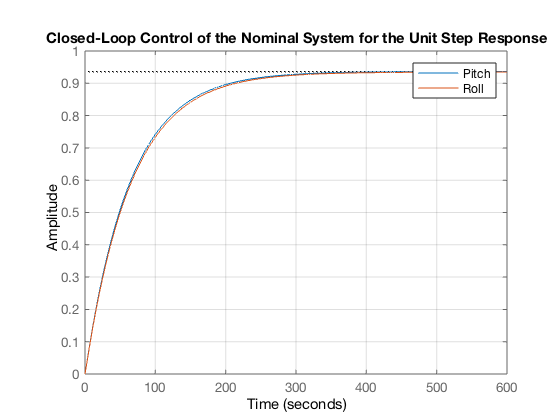

In [111]:
T_theta = feedback(G_theta*C_theta, 1); % Unity feedback
T_phi = feedback(G_phi*C_phi, 1);

% Plot Step Response
hold on;
step(T_theta);
step(T_phi);
title('Closed-Loop Control of the Nominal System for the Unit Step Response');
legend('Pitch' , 'Roll');
grid on;

#### B) Corresponding Control Effort

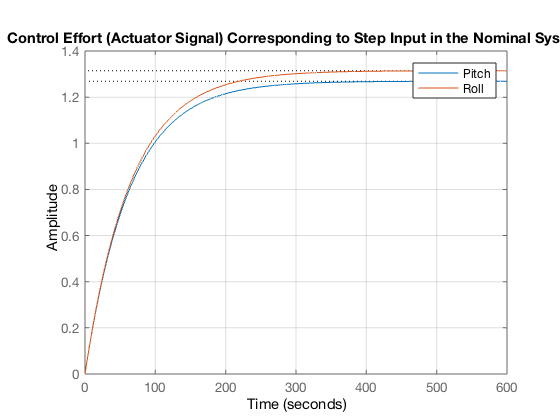

In [112]:
U_theta = C_theta / (1 + G_theta * C_theta); % Equivalent to feedback(K, G)
U_phi = C_phi / (1 + G_phi * C_phi); 

% Plot Step Response
hold on;
step(U_theta);
step(U_phi);
title('Control Effort (Actuator Signal) Corresponding to Step Input in the Nominal System');
legend('Pitch' , 'Roll');
grid on;

#### C) Singular Values and Bode Plots

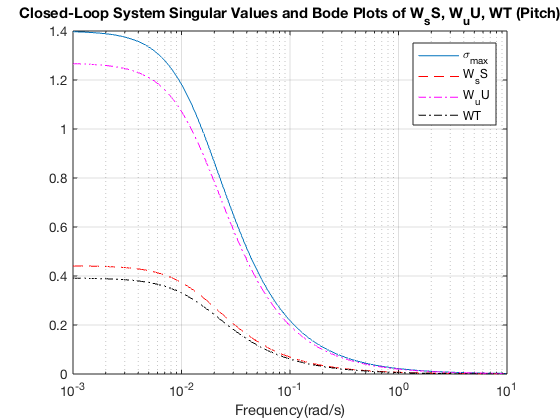

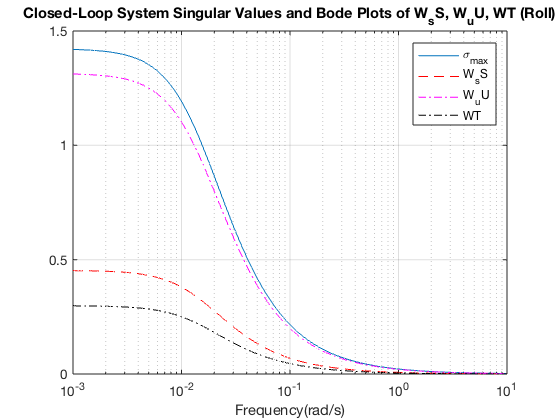

In [127]:
omega  = logspace(-3,1,300);

figure;
[mag_g1,phase_g1]=bode(CL1,omega);
sig_g1=sigma(CL1,omega);
semilogx(omega,sig_g1,omega,mag_g1(1,:),'--r',omega,mag_g1(2,:),'-.m',...
omega,mag_g1(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots of W_sS, W_uU, WT (Pitch)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

figure;
[mag_g2,phase_g2]=bode(CL2,omega);
sig_g2=sigma(CL2,omega);
semilogx(omega,sig_g2,omega,mag_g2(1,:),'--r',omega,mag_g2(2,:),'-.m',...
omega,mag_g2(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots of W_sS, W_uU, WT (Roll)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

#### 2.4. Improvement Cycle


  Test bounds:  0.423 <=  gamma  <=  0.581

   gamma        X>=0        Y>=0       rho(XY)<1    p/f
  4.96e-01     5.4e-06     0.0e+00     2.859e-21     p
  4.58e-01     5.4e-06     0.0e+00     3.112e-24     p
  4.40e-01     5.4e-06     0.0e+00     5.441e-17     p
  4.32e-01     5.4e-06     0.0e+00     2.825e-16     p
  4.27e-01     5.4e-06     0.0e+00     1.236e-17     p

  Best performance (actual): 0.427


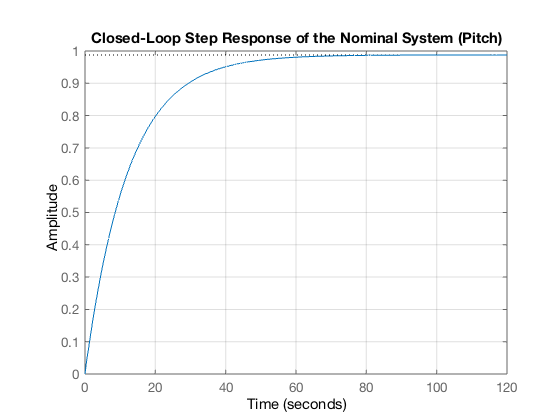

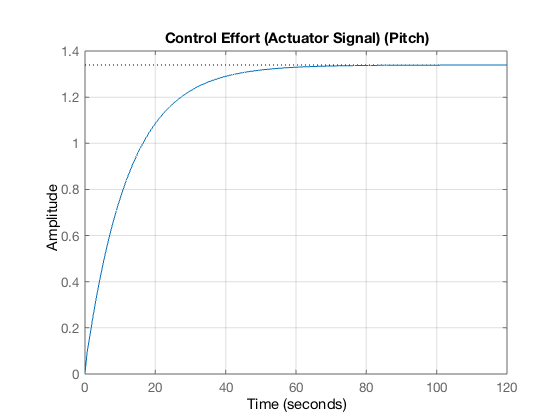

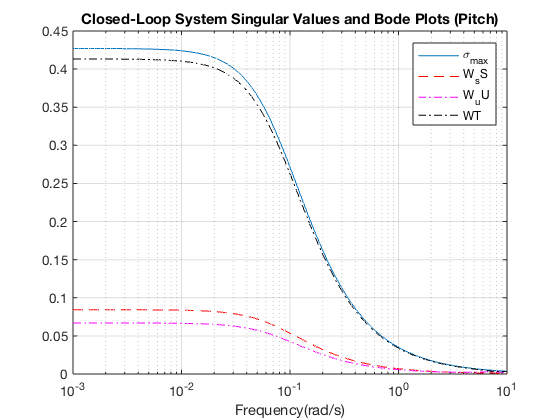

In [100]:
% Modified Weights
W_u = 0.05;
a = 1;
W_s = a * (s^2 + 26.68*s + 185.23) / ((s + 0.001)*(s + 26.68)*(s + 1000));

% Build Generalized Plant
G_theta_p = augw(G_theta , W_s , W_u , W_theta);

% Synthesize H∞ Controller
[C_theta , CL , gamma , info] = hinfsyn(G_theta_p , 1 , 1 , 'method' , 'ric' , 'Display' , 'on');

T = feedback(G_theta*C_theta, 1);
U = C_theta / (1 + G_theta * C_theta);

figure;
step(T);
title('Closed-Loop Step Response of the Nominal System (Pitch)');
grid on;

figure;
step(U);
title('Control Effort (Actuator Signal) (Pitch)');
grid on

figure;
omega  = logspace(-3,1,300);
[mag_g,phase_g]=bode(CL,omega);
sig_g=sigma(CL,omega);
semilogx(omega,sig_g,omega,mag_g(1,:),'--r',omega,mag_g(2,:),'-.m',...
omega,mag_g(3,:),'-.k');
title("Closed-Loop System Singular Values and Bode Plots (Pitch)");
xlabel("Frequency(rad/s)");
legend('\sigma_{max}','W_sS','W_uU','WT');
grid on;

#### 2.5. Testing on Uncertain Systems

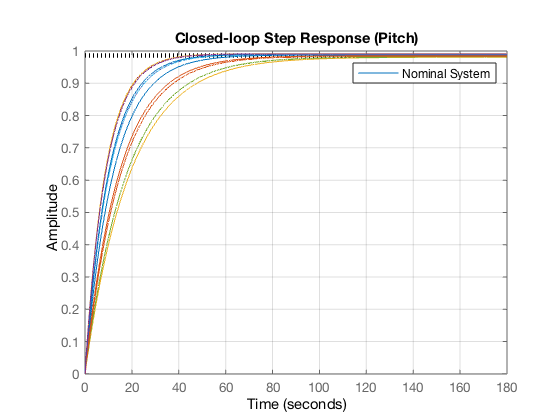

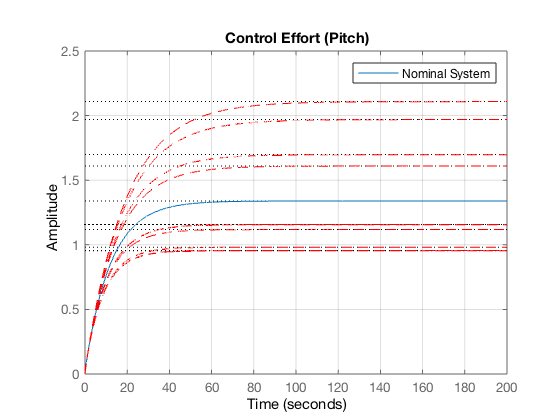

In [99]:
% Simulate step response for each sample
figure;
hold on;
T = feedback(G_theta*C_theta, 1);
step(T);
for i = 1:num_samples
    T = feedback(G_theta_samples(:,:,i)*C_theta, 1);  % Closed-loop
    step(T);  % Simulate for 5 seconds
end
title('Closed-loop Step Response (Pitch)');
legend('Nominal System')
grid on;
hold off;

figure;
hold on;
U = C_theta / (1 + G_theta * C_theta); 
step(U);
for i = 1:num_samples
    U = C_theta / (1 + G_theta_samples(:,:,i)*C_theta);
    step(U , '--r');
end
title('Control Effort (Pitch)');
legend('Nominal System')
grid on;